In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(parent_dir)
from src.utils import calculate_eer


In [2]:
%cd ../..

d:\Projekt


d:\Projekt\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [28]:
csv_path = os.path.join(parent_dir, 'data', 'fusion_win', 'arcface_train_1.parquet')
# csv_path = os.path.join('test.parquet')

In [29]:
data = pd.read_parquet(csv_path, engine='pyarrow')

In [30]:
data.dropna(inplace=True)

In [31]:
data

,video_id,person_id,embedding,frame_id
0,1,id00198,"[90.56102, -65.56271, -93.72305, 62.51121, 183...",0.0
1,1,id00198,"[46.289593, -81.14029, -68.73383, 54.044365, 1...",1.0
2,1,id00198,"[33.78087, -86.7204, -57.834084, 70.40548, 208...",2.0
3,10,id00198,"[37.99424, -40.28535, -18.296997, 36.80046, 99...",0.0
4,10,id00198,"[39.579983, -30.340221, -45.538246, 20.224445,...",1.0
...,...,...,...,...
15384,98,id00417,"[107.633224, -95.87865, 35.57868, 55.08042, 19...",2.0
15385,98,id00417,"[100.24002, -117.17236, 3.4130895, 52.308815, ...",3.0
15386,99,id00417,"[102.729454, -85.09616, -23.799757, 66.663284,...",0.0
15387,99,id00417,"[93.56575, -110.42533, -16.705309, 67.27733, 2...",1.0


In [32]:
from src.model import load_model
import ast
model = load_model('adaface')

labels = data['person_id'].values
embeddings = data['embedding']
# embeddings = np.array([np.array(ast.literal_eval(e)) for e in embeddings])
print(type(embeddings))
embeddings = np.array(embeddings.tolist())
print(embeddings.shape)
num_samples = len(embeddings)
scores = []
class_labels = []
chunk_size = 5000
for i in range(0, num_samples, chunk_size):
    for j in range(i + 1, num_samples, chunk_size):
        print("Processing chunk", i, j)

        emb_chunk = embeddings[i:i + chunk_size]
        emb_chunk_2 = embeddings[j:j + chunk_size]

        score_chunk = model.compute_similarities(emb_chunk, emb_chunk_2)

        labels_chunk = labels[i:i + chunk_size]
        labels_chunk_2 = labels[j:j + chunk_size]
        labels_matrix = np.equal(labels_chunk[:, None], labels_chunk_2)
        np.fill_diagonal(labels_matrix, False)

        upper_triangle_indices = np.triu_indices_from(score_chunk, k=1)
        try:
            class_label = labels_matrix[upper_triangle_indices]
            score = score_chunk[upper_triangle_indices]
            class_labels.extend(class_label)
            scores.extend(score)
        except:
            continue

data = pd.DataFrame({
    'label': class_labels,
    'score': scores
})

d:\Projekt\models\AdaFace\inference.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  statedict = torch.load(adaface_models[architecture])['state_dict']


<class 'pandas.core.series.Series'>
(14777, 512)
Processing chunk 0 1
Processing chunk 0 5001
Processing chunk 0 10001
Processing chunk 5000 5001
Processing chunk 5000 10001
Processing chunk 10000 10001


In [33]:
results_json = {}

Text(0.5, 1.0, 'Adaface - same (1) and different (0) people embeddings similarity')

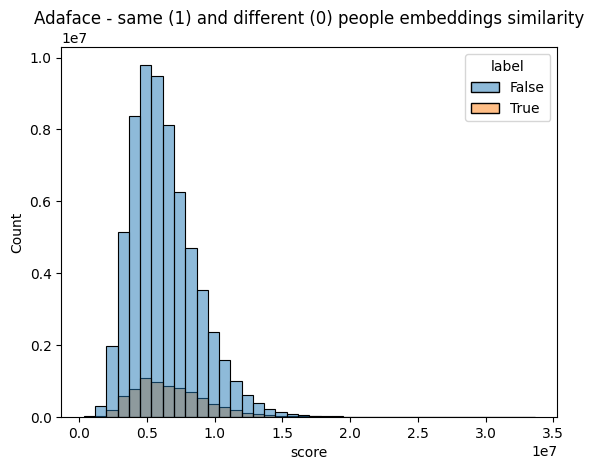

In [34]:
sns.histplot(data = data, x = 'score', hue='label',bins = 40)
plt.title('Adaface - same (1) and different (0) people embeddings similarity')

In [10]:
same_person = data[data['label'] == 1]
diff_person = data[data['label'] == 0]

In [11]:
print(f"Same person mean: {same_person['score'].mean()}")
print(f'Same person std: {same_person["score"].std()}')
print(f"Diff person mean: {diff_person['score'].mean()}")
print(f'Diff person std: {diff_person["score"].std()}')

Same person mean: 0.9182723760604858
Same person std: 0.05316135659813881
Diff person mean: 0.8927942514419556
Diff person std: 0.05297156423330307


In [12]:
results_json['eval'] = {}
results_json['eval']['similarity_distribution'] = {}

In [13]:
results_json['eval']['similarity_distribution']['same_person_mean'] = round(same_person['score'].mean(), 6)
results_json['eval']['similarity_distribution']['same_person_std'] = round(same_person['score'].std(), 6)
results_json['eval']['similarity_distribution']['diff_person_mean'] = round(diff_person['score'].mean(), 6)
results_json['eval']['similarity_distribution']['diff_person_std'] = round(diff_person['score'].std(), 6)

In [14]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 0.918272,
   'same_person_std': 0.053161,
   'diff_person_mean': 0.892794,
   'diff_person_std': 0.052972}}}

In [15]:
thresholds = np.linspace(0.5, 1, 51)

In [16]:
accs = []
f1s = []
precs = []
recs = []
fars = []
frrs = []

In [17]:
ground_truth = data['label']
for t in thresholds:
    decisions = data['score'] > t
    acc = accuracy_score(ground_truth, decisions)
    f1 = f1_score(ground_truth, decisions)
    prec = precision_score(ground_truth, decisions)
    rec = recall_score(ground_truth, decisions)
    FP = np.sum((ground_truth == 0) & (decisions == 1))
    FN = np.sum((ground_truth == 1) & (decisions == 0))
    TP = np.sum((ground_truth == 1) & (decisions == 1))
    TN = np.sum((ground_truth == 0) & (decisions == 0))
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    fars.append(FAR)
    frrs.append(FRR)
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    

In [18]:
threshold, eer = calculate_eer(thresholds, fars, frrs)

In [19]:
print(threshold, eer)

0.9172856745940501 0.39074984952666447


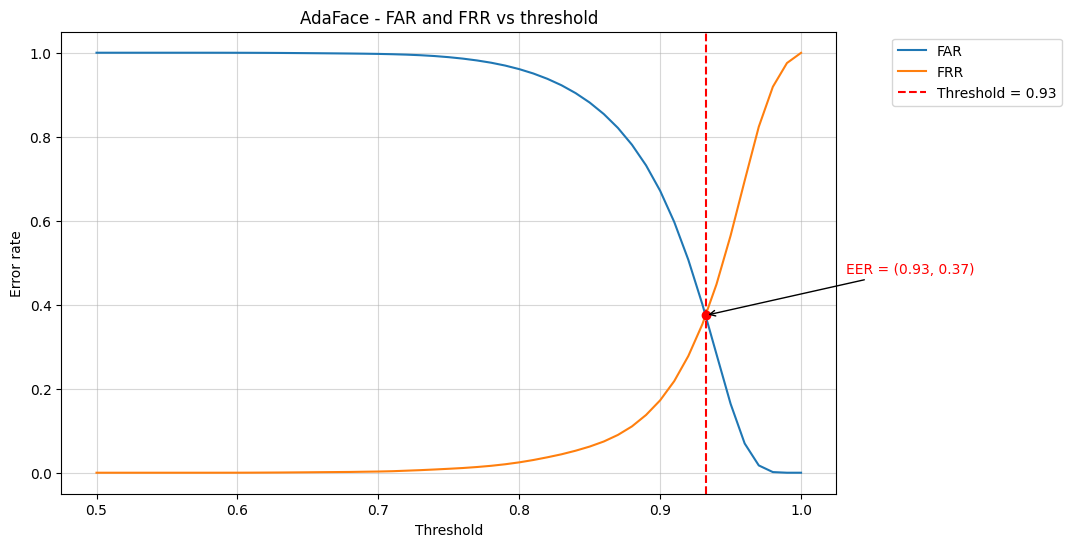

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fars, label='FAR')
plt.plot(thresholds, frrs, label='FRR')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.scatter(threshold, eer, color='red', zorder=2)
plt.annotate(
    f'EER = ({threshold:.2f}, {eer:.2f})', 
    xy=(threshold, eer), 
    xytext=(threshold + np.max(thresholds)/10, eer + 0.1),  # Adjust text position
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10,
    color='red'
)
plt.title('AdaFace - FAR and FRR vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.grid(alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

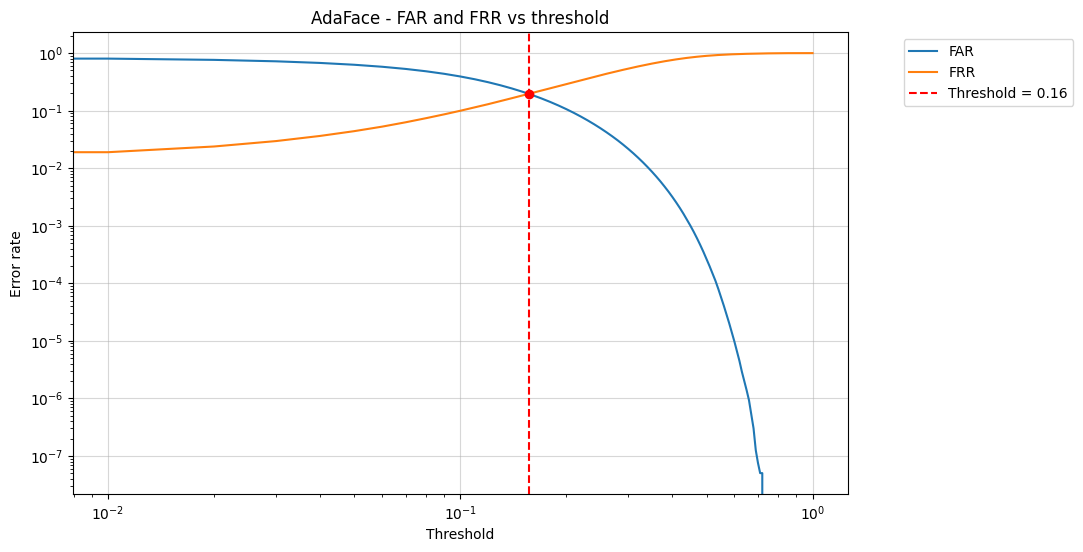

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fars, label='FAR')
plt.plot(thresholds, frrs, label='FRR')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.scatter(threshold, eer, color='red', zorder=2)
plt.title('AdaFace - FAR and FRR vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

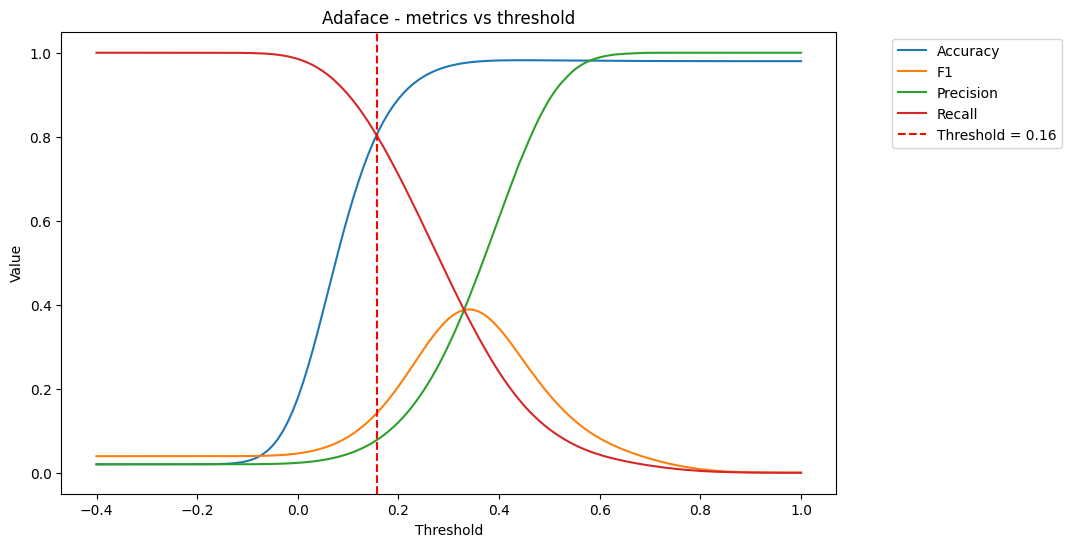

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accs, label='Accuracy')
plt.plot(thresholds, f1s, label='F1')
plt.plot(thresholds, precs, label='Precision')
plt.plot(thresholds, recs, label='Recall')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Adaface - metrics vs threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [19]:
decisions = data['score'] > threshold
acc = accuracy_score(ground_truth, decisions)
f1 = f1_score(ground_truth, decisions)
prec = precision_score(ground_truth, decisions)
rec = recall_score(ground_truth, decisions)
FP = np.sum((ground_truth == 0) & (decisions == 1))
FN = np.sum((ground_truth == 1) & (decisions == 0))
TP = np.sum((ground_truth == 1) & (decisions == 1))
TN = np.sum((ground_truth == 0) & (decisions == 0))
FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(f'Accuracy: {round(acc, 5)}')
print(f'F1: {round(f1, 5)}')
print(f'Precision: {round(prec, 5)}')
print(f'Recall: {round(rec, 5)}')
print(f'FAR: {round(FAR, 7)}')
print(f'FRR: {round(FRR, 5)}')

Accuracy: 0.80387
F1: 0.14132
Precision: 0.07747
Recall: 0.80377
FAR: 0.1961301
FRR: 0.19623


In [20]:
results_json 

{'eval': {'similarity_distribution': {'same_person_mean': 0.296355,
   'same_person_std': 0.160391,
   'diff_person_mean': 0.085453,
   'diff_person_std': 0.090646}}}

In [21]:
results_json['eval']['metrics'] = {}
results_json['eval']['metrics']['accuracy'] = round(acc, 6)
results_json['eval']['metrics']['f1'] = round(f1, 6)
results_json['eval']['metrics']['precision'] = round(prec, 6)
results_json['eval']['metrics']['recall'] = round(rec, 6)
results_json['eval']['metrics']['far'] = round(FAR, 6)
results_json['eval']['metrics']['frr'] = round(FRR, 6)
results_json['eval']['metrics']['eer'] = round(eer, 6)
results_json['eval']['threshold'] = round(threshold, 6)

In [22]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 0.296355,
   'same_person_std': 0.160391,
   'diff_person_mean': 0.085453,
   'diff_person_std': 0.090646},
  'metrics': {'accuracy': 0.803868,
   'f1': 0.141322,
   'precision': 0.077472,
   'recall': 0.803769,
   'far': 0.19613,
   'frr': 0.196231,
   'eer': 0.196446},
  'threshold': 0.156468}}

## Test

In [23]:
csv_path = os.path.join(parent_dir, 'data', 'scores', 'adaface_test_front_base_scores.csv')
data = pd.read_csv(csv_path)

In [24]:
ground_truth = data['label']

In [25]:
decisions = data['score'] > threshold
acc = accuracy_score(ground_truth, decisions)
f1 = f1_score(ground_truth, decisions)
prec = precision_score(ground_truth, decisions)
rec = recall_score(ground_truth, decisions)
FP = np.sum((ground_truth == 0) & (decisions == 1))
FN = np.sum((ground_truth == 1) & (decisions == 0))
TP = np.sum((ground_truth == 1) & (decisions == 1))
TN = np.sum((ground_truth == 0) & (decisions == 0))
FAR = FP / (FP + TN)
FRR = FN / (FN + TP)
print(f'Accuracy: {round(acc, 5)}')
print(f'F1: {round(f1, 5)}')
print(f'Precision: {round(prec, 5)}')
print(f'Recall: {round(rec, 5)}')
print(f'FAR: {round(FAR, 7)}')
print(f'FRR: {round(FRR, 5)}')

Accuracy: 0.83271
F1: 0.16165
Precision: 0.08988
Recall: 0.80218
FAR: 0.16666
FRR: 0.19782


In [26]:
results_json['test'] = {}
results_json['test']['metrics'] = {}
results_json['test']['metrics']['accuracy'] = round(acc, 6)
results_json['test']['metrics']['f1'] = round(f1, 6)
results_json['test']['metrics']['precision'] = round(prec, 6)
results_json['test']['metrics']['recall'] = round(rec, 6)
results_json['test']['metrics']['far'] = round(FAR, 6)
results_json['test']['metrics']['frr'] = round(FRR, 6)

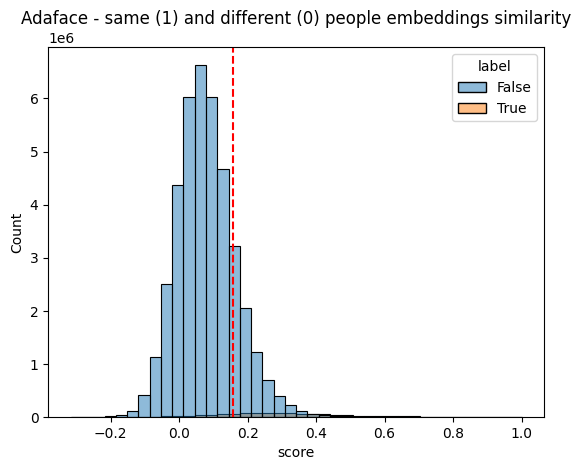

In [27]:
sns.histplot(data = data, x = 'score', hue='label',bins = 40)
plt.title('Adaface - same (1) and different (0) people embeddings similarity')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')

In [28]:
same_person = data[data['label'] == 1]
diff_person = data[data['label'] == 0]

In [29]:
results_json['test']['similarity_distribution'] = {}

In [30]:
results_json['test']['similarity_distribution']['same_person_mean'] = round(same_person['score'].mean(), 6)
results_json['test']['similarity_distribution']['same_person_std'] = round(same_person['score'].std(), 6)
results_json['test']['similarity_distribution']['diff_person_mean'] = round(diff_person['score'].mean(), 6)
results_json['test']['similarity_distribution']['diff_person_std'] = round(diff_person['score'].std(), 6)

In [31]:
fars=[]
frrs=[]
ground_truth = data['label']
for t in thresholds:
    decisions = data['score'] > t
    FP = np.sum((ground_truth == 0) & (decisions == 1))
    FN = np.sum((ground_truth == 1) & (decisions == 0))
    TP = np.sum((ground_truth == 1) & (decisions == 1))
    TN = np.sum((ground_truth == 0) & (decisions == 0))
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    fars.append(FAR)
    frrs.append(FRR)


In [32]:
_, eer = calculate_eer(thresholds, fars, frrs)

In [33]:
results_json['test']['metrics']['eer'] = round(eer, 6)

In [34]:
results_json

{'eval': {'similarity_distribution': {'same_person_mean': 0.296355,
   'same_person_std': 0.160391,
   'diff_person_mean': 0.085453,
   'diff_person_std': 0.090646},
  'metrics': {'accuracy': 0.803868,
   'f1': 0.141322,
   'precision': 0.077472,
   'recall': 0.803769,
   'far': 0.19613,
   'frr': 0.196231,
   'eer': 0.196446},
  'threshold': 0.156468},
 'test': {'metrics': {'accuracy': 0.832713,
   'f1': 0.161654,
   'precision': 0.089884,
   'recall': 0.802179,
   'far': 0.16666,
   'frr': 0.197821,
   'eer': 0.184554},
  'similarity_distribution': {'same_person_mean': 0.29183,
   'same_person_std': 0.156275,
   'diff_person_mean': 0.078806,
   'diff_person_std': 0.084577}}}

In [35]:
import json
with open(f"{parent_dir}/results/adaface_front.json", "w") as outfile:
    json.dump(results_json, outfile)